# Q-learning with neural networks

In [1]:
# a few packages we need to import
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython 

import torch

import pendulum

The goal of this homework is to implement the Q-learning with a neural network for the Q function to solve the inverted pendulum problem.

<img src='pendulum.png' width="120">

In the following, we write $x = \begin{pmatrix} \theta \\ \dot{\theta} \end{pmatrix}$ as the vector of states of the system.

## System dynamics
* The system dynamics is implemented in the `pendulum.py` function. The dynamics is implemented in `pendulum.step`.
* The allowed control inputs are $[-5,0,5]$

## Cost function
The goal is to find a policy that minimizes the following cost
$$\min \sum_{n=0}^N \alpha^n g(x,u)$$
where
$$g(x,v,u) = 0.01*(1-\cos(x-\pi))^2 + 0.0001* v^2 + 0.000001*u^2$$
which gives a high cost for states far from $\pi$ (i.e. far from the inverted position) or states with non zero velocity or high controls



## Q-learning algorithm to implement
For each episode:
* Initialize the episode $x_0 = [0,0]$
* For each step of the episode:
    * Select $u_n$ using an $\epsilon$-greedy policy
    * Compute the next state $x_{n+1}$
    * Compute the target $y_n = g(x_n,u_n) + \alpha \min_a Q(x_{n+1},a)$
    * Do one SGD step on the neural network parameters to minimize $(Q(x,u) - y_t)^2$


## Parameters:
* Episode length 100 steps
* Discount factor $\alpha = 0.99$
* Learning rate (for SGD) $0.1$
* $\epsilon = 0.1$ (for policy exploration)



## Using PyTorch
You need to install and use PyTorch for the neural network and do the optimization. 

You may want to use the following functions:
* [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

The neural network is given below

In [2]:
## we define the neural network to be used for Q-learning
## 2 hidden layers with 64 nodes
## 2 inputs (state)
## 3 outputs for the 3 possible controls
D_in, H, D_out = 2, 64, 3

q_function = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out)
)

## we initialize the network parameters to 0
for params in q_function.parameters():
    params.data.normal_(0, 0.01)

### possible controls
possible_controls = np.array([-5.,0.,5.])

# Questions:
1. Implement the Q-learning algorithm described above (this is the simple version of Q-learning - not the DQN version)
2. Test that it works with and without pushes using the code below
3. Plot the cost per episode (to visualize learning)
4. Plot the learned value function (in 2D as a function of pendulum position and velocity) as well as the policy.
5. Describe the algorithm and put the plots in the pdf. Include a video of the pendulum.

## Testing
You can test your results with the code below which use the Q-function to create a controller send to the `animate_robot` function.
You can choose to save also a movie of the animation and toggle the animation with a disturbance.

In [3]:
x0 = np.zeros((2,1))
def controller(x):
    u_pred = torch.argmin(q_function(torch.as_tensor(x, dtype=torch.float).unsqueeze(0))).item()
    u = possible_controls[u_pred]
    return u
    
pendulum.animate_robot(x0,controller,push=False, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAAbjG1kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5IGxvb2thaGVhZF90aHJlYWRz
PTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADSxliIQAEf/+94gfMstp+TrX
chHnrS6tH1DuRnFepL3+IAAAAwAAAwACHHgr8h1jA36boAAANaAGnDnk/0uKTTxANBMklOx5Afoy
zTNjGZoxSMjI2XqpG5muyFpkpA6oCAPVnxylzDLYhuV6SiLysV19ZrkfNVeuuW3Q9PnAIUDhMZl7
zUCMeOI9XyhO34h2N6JqaLaBMEJBECZ+5uHUUpUwEyHMK0SddgK8GQ+8N9YKy9+mi5xcrkYkRWJQ
ER7+UzLKhVSfJl1dCKS9cKV2QpOCIcN2cB6dc7SsaFnK+lNL704KVLG608M5FPwh6EL0EBwAfACH
U1dX1oJZzgeYkF9jIDc1B3hLlj82wiQfYvK10RzuN9Q1U62r1OscElerAZGzgImHEQ9AUCDlSjLB
CymJ0ZW3j+UdffVRQ4cAzpTgLL/sjPAGF6YX+yqMIy2LXBh9gX6Pdyg9TIX2+Qqsog+WDM8kjQI5
D1HDegmYnuqXpe/MBsNnkgpFFgiOvUE347T2ajp0qdYwaDMgqlYf58zP9aYJ3tJmPvGaMh2VDhGm
bYiXwFVLHq36Opwl7f12x7Sxb1T9184FQlIt/RBporGW/9z2nx2yoEwSMv63fDm8c5dmi2IKv5xj
dW4tSBSTS+kLL5X5/FQkLhX9ckakEaSgYmb4KFzr+7zD2pktr2209d3VyuJMbIx0+qpYJDVQjrgN
0Wti9ZNxLnWUCvXYDf0ZvAJQZU1iwCen8eYbjTyQ78hjP2OMtxQ6rhx4MRvCG0CM9lrLuUAAAAMA
AAMAAAMAA4vC7v82dVh/Yjf5u6X9pKY2D1vSU0FyAvT9C0i2lOu56d10+xKTprmLCJQQx23WAdIq
DMSBktDH4Q6IoXbbibqSoFfHlQS8hJvY4sYuZ+gcP0Z7klP+frIq94jQAdPEr9QpOUL3t+oRw8Zz
CpAnQDVPU0xLy1EylDTmnpUkPlf8m2WgRe/srmsI+wizvgfknC2JVyiyezagM6t6r6yvnCZlGgNZ
o8k9/vYUqjLvlvYNseXk/U6o/WtRML80H01/7OIlGxztIEApdHzUA21BEJhD97z0nqKjtaz9E21i
fhLF4p3gwKA4rm0+liGZsTQkEP+wdDciC/4bfX06KaTguiNbM9DLQg/6nq4APWG6vXw/qhQ09ntO
zR2fY7BmnMbU9vJ8wGWJ9HSYi3ccBJ+NT5hPRpr/RGbkeTiRFK1JASKRA2uGZ7Vjb8AAAAMAAAMA
ANK3cz/AeM1zm0O1T6opP6vJxy5netqwLbmzOPJp+iCSOc4y3MSjW3gLXUBv3R5BTQt5dmFpKUJh
gIlmf7MA1tTAB79p3P8xMZbGtu1iXWSNvuJOwtiKB3pPFOe8x6FELG2nW4Vxuulk2bLhy9HpBcJl
wzTQo+ER/vLUhs+6nBb6xrnPGgQpvKbqQBTv9iSNsgYzbhO/JwW8B3UfiuZ9iF3UCuzDYVwE3DsC
1mZR7kOcB+a9eRCXUb+F2KqpVC/8TP9Amny6wGJEuKHlIhnhDPEzCf763neu+No6j5G3SvEXQQ7P
wQY1T2gBfnDaPe9MzT8lojWRIhJsF6OW+QXU816ah95Iuzqr1f10lSzSn61vKYssX5F61sK7wPUb
Fn5/3/9FvS1pt7iulOXjVBOIH4CeJWEXmLLDdaiiZOjs+3kaFekHy3ePF9yVRFLFRCfQFPeOIMep
AmXeqQH8kKVdgBzBEH5e8AJE/zoYVtuERzNfVSTKiX/Hgu0ZgGT5Y7TV1qW3ADNM7QKcH3v4uzYo
+TMEq5I0ydbUL4UIzer5Ky4qG+P/wEaGuCrqrZsOdr6Vrakx3Q6xEXNK3thnIWqTWAcCUmJ5xDdz
Ezkb8nEVDiH+JsZmwjSzAFtFfExh4+RpKT/8+W5fzdKsu4AIYgrJWMl0YkhiMXkX2DB+xUkpciix
sBvYN0OVyOUx3luHvCwQ8TLU6aj3GWMM8Zwm71u6m+zAlv7q95VofTGBeXRs0LjD4Eqa8qa75y52
akqNMNKt6qrgh6cwjUxcuYoWOrEWPbb/IQ2RbQRVin9ABCDfKxVmqDV0KEtF29Vs+af+3s8NF/v+
FZ5ZPJTGlejjyQepi8SYclMxxkQP23Wqs9Hk/gKD+8bV6C0CXsyJdyD8vd8KGpVW7ADUEXrYSbG4
Mw56rXY9JlONSUSVN/6Ndu2M67dvRmhXGXupjIKtGCa313uaukgwfOV12EShPEQYjploAQHQnkAL
ktgMzl51mXXf/9IAfEKt/5bv6o9S+ePrqNGlwumFt2x2pZLjxAcjAPkMmZiVp6qdypjn7PZIVeqd
Tz75KFUMadq95UZKhvW2MY7ZbeNmJ2tdPWP99h5yDMq7NW+VD18KRDoAzdyA+QvMgl0iU2mDRh90
QbA4CUtIxrhmcivrGMxkOxyGG9ZMMNQAE957AdXz0Hnr4NKzmo1BBNiDYEvGOYNj3M762j80wSAZ
5SBX2cLRngvpUoeXUc3g9l2NO7UxFAMWkCNWlQgwnLC4hQOIw9ymlYu//hgvxzmb8NNP1junJRKb
wftmGvakbYSr2oJEc9zL6mypWUwgQfKm3/tdsoeaqXA57ZSCFVlQFBMHRtsEpqkAKpx0L4hKY+x/
Aq2Lct/d50EF4j6aafHIJ3qIL+f4w3QNyRoP+9pRUpf8gzAWtyMQrnbOj/6Ts9++vXS14lj9QR1s
MuG9QITe79U5odyrN1A+oXsim7dWpExi2Sxoz5A+YwEphtvkanX9q445LFC3gSKNOsIcUnau3ZxP
V3Zgh5Iufe9xhuFK8zI2pmcJ1dOx3Z6su2nz/9sMjm9u8yvqmv9rB++CpPY/wsGptkNmXQ0dmOOD
+Mt4VichmsElv97TI58AsCKTm5Tyj4BIdaUEYTG0flkBqQ3jtAG6ss0u8nHA4Kv1Wq6m7S+TEpVH
O+EehpPbMrZPUfb3IDfia

### 1. Q learning algorithm

In [4]:
class Q_learning:
    def __init__(self, x_0, action_set, q_network, eta = 0.1, alpha = 0.99, epsilon = 0.1):
        
        self.x_0 = x_0
        self.n_states = len(x_0)
        self.n_actions = len(action_set)
        self.action_set = action_set

        # Q function
        self.q_network = q_network

        # learning parameters (learning rate, discount factor, exploration rate)
        self.eta = eta
        self.alpha = alpha
        self.epsilon = epsilon

        # optimizer and loss
        self.optimizer = torch.optim.SGD(self.q_network.parameters(), lr= self.eta)
        self.loss_function = torch.nn.MSELoss()
        
    def cost_function(self, state, u):
        theta, theta_dot = state[0], state[1]
        return (0.01 * (1 - np.cos(theta - np.pi))**2 + 
                0.0001 * theta_dot**2 +
                0.000001 * u**2)  

    def select_action(self, state):
        if np.random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.as_tensor(state, dtype= torch.float).reshape(1, -1)
                q_values = self.q_network(state_tensor)
                action_idx = torch.argmin(q_values).item()
        else:
            action_idx = np.random.randint(0, self.n_actions)
        return action_idx

    def update(self, state, next_state, action_idx, cost):
        state_tensor = torch.as_tensor(state, dtype= torch.float).reshape(1, -1)
        next_state_tensor = torch.as_tensor(next_state, dtype= torch.float).reshape(1, -1)

        # Current Q-value
        q_values = self.q_network(state_tensor)
        q_value = q_values[0, action_idx]

        # Next Q-value: y = g(x,u) + alpha * min_a Q(x_next, a)
        with torch.no_grad():
            next_q_values = self.q_network(next_state_tensor)
            next_q_min = torch.min(next_q_values)

            target = torch.as_tensor(cost, dtype=torch.float32) + self.alpha * next_q_min
        
        loss = self.loss_function(q_value, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()    

    def trainer(self, model, n_episodes=1000, episode_length=100):
        episode_costs = []

        for episode in range(n_episodes):
            state = self.x_0.copy().flatten()
            total_cost = 0

            for step in range(episode_length): 
                action_idx = self.select_action(state)
                u = self.action_set[action_idx]
                
                cost = self.cost_function(state, u)
                total_cost += cost

                next_state = model.step(state.reshape(-1, 1), u).flatten()
                self.update(state, next_state, action_idx, cost)

                state = next_state
            
            episode_costs.append(total_cost)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode+1}, Avg Cost: {np.mean(episode_costs[-100:]):.4f}")
                # [print(f"{name}:\n{param.data}") for name, param in q_function.named_parameters()]
        return episode_costs

    def controller(self, state):
        with torch.no_grad():
            state_tensor = torch.as_tensor(state, dtype= torch.float).reshape(1, -1)
            q_values = self.q_network(state_tensor)
            action_idx = torch.argmin(q_values).item()
            u = self.action_set[action_idx]
        return u

In [6]:
Q = Q_learning(x0, possible_controls, q_function, eta=0.1, alpha=0.99, epsilon=0.1)
learning_costs = Q.trainer(pendulum, n_episodes= 5000, episode_length= 100)

Episode 100, Avg Cost: 3.5652
Episode 200, Avg Cost: 3.4242
Episode 300, Avg Cost: 3.0890
Episode 400, Avg Cost: 3.0755
Episode 500, Avg Cost: 3.0768
Episode 600, Avg Cost: 2.6203
Episode 700, Avg Cost: 2.2647
Episode 800, Avg Cost: 2.4231
Episode 900, Avg Cost: 2.1996
Episode 1000, Avg Cost: 1.8809
Episode 1100, Avg Cost: 1.7304
Episode 1200, Avg Cost: 1.7104
Episode 1300, Avg Cost: 1.6380
Episode 1400, Avg Cost: 1.5991
Episode 1500, Avg Cost: 1.6265
Episode 1600, Avg Cost: 1.5941
Episode 1700, Avg Cost: 1.5926
Episode 1800, Avg Cost: 1.5656
Episode 1900, Avg Cost: 1.5647
Episode 2000, Avg Cost: 1.5678
Episode 2100, Avg Cost: 1.5490
Episode 2200, Avg Cost: 1.5339
Episode 2300, Avg Cost: 1.5144
Episode 2400, Avg Cost: 1.5064
Episode 2500, Avg Cost: 1.4639
Episode 2600, Avg Cost: 1.2689
Episode 2700, Avg Cost: 1.2322
Episode 2800, Avg Cost: 1.2602
Episode 2900, Avg Cost: 1.2539
Episode 3000, Avg Cost: 1.2287
Episode 3100, Avg Cost: 1.2270
Episode 3200, Avg Cost: 1.2296
Episode 3300, Avg

### 2a. Without Pushes

In [7]:
pendulum.animate_robot(x0,Q.controller,push=False, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABrD21kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5IGxvb2thaGVhZF90aHJlYWRz
PTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADS1liIQAEP/+94G/MstfIrrJ
cfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsADpCLH/2+kONwAT9lg/NYjL/Fo
B9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2fy1TN9QNLS2doYg16nA3KBIIC
jrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17mhCeWbA7zyXROB8c1qwBwG6mF
4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+LI/6q7q3wu/lDZN9tIlTOzRJ
5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8riq2xS9wgxfOhJNJt6YhrXMm7zj
Vbb5XjgbkHcxnQGuWAediwJYqi3fm4ujHJ0imNhaD37uUGnV0uhFHwdHqWMHnkkZYv5dDA2wu6b3
OQ9KRwn5X82CXdBrwTfk3PfgmQi7fk9RABc2Y/lr+wk7/NGHIW6xbWrCQjWI3kMgmnZdCoBs9vyR
LBTpCVIj7av8Cn5DSXlEn/Sd+3NrATU5DNYJFIv98ZA73iur1uVp0nGsXxBFlJ1H2+4c5v0sc6J3
GHQJ+QWfXMMMpnrGfqYO8ABZaLotsFB/LHkbFwuip7F+yFSJmOPjnv2p6EsCzZ4ktjM8W1dXaEG2
suS0/qszjbE87HSzI2X2rNhD1OEBMVUgEqBo5/9NmB0Bo9GqAALehZ8i1grAAAADAAAcsN45Ool3
dJjcC5l1ionKhG+MbpKQwX9Lmw3KGL0O0QyYWXsIguFmSYkh5hJknwu1VngI/x2VwWdi+wiiht8Z
vG/IJ79iJJkkKO6xBJzS+KpO0D1md0phIkCGUmoZrKZNWpGS6dQrHSQW+963rcDZzT1NMS8tRNUe
b2wCfNRyv+Tcia9FT0SgtuJ7fKTUBknC2JVyjJi/5zQcq3r6yvnDACSsyt9zsUqRMReLZNXTkCKO
FOcvztolAYDsH8xDZ//L1YoKw78CLvQjFuWyXEOncrtWPLVJ6io7Ws/RNtaL2uIyQiSGOHETDD9k
+kAEgkbCOj0AafTCUyiZZAMXxf/6RAxy84pHqHPjYzpxHOANFa9LtSZjr5T1+4zLI0qUW3UxRv36
0dogrYU5TsEQFXNwPP/+kNvVw2CvdpTbcWNR4y5ic6edG14lOqpXWxDRK1srBLMfv7M9kchx9HVR
Hq1VCJ9TpyuS5Sm8+NB/IduqyCMIfY2MEKNSyX/z6kthgRSFGnFIZLFY7WsoR2286MYdS3EwwESz
P8RqR7iyUG/adz/MTGXSRcjGb7PNHcDSnCxGe59binPeY9CiFjcV9c+43XSybNlPCElMGaIgDxfd
V0vm/3lqQ2fdV852vp1iw2S+sHXBbw+v/VbI32DZLbFDYELgYpfHFvL/Yhd1Arsw34FNikk8/Y4y
j3Ic4D8162lFQAF/hIK6yDzOqQ+ODPhZc7T8CbyCK5vNc9opXnUq5jM9c+kdt26Jg01lwFBHDHYv
aQc2JWlvKdGFoR4iWA8INIdCTNf8QC8opsyCMwm1VwBwXsKmcCNydTVoiTnsC4nrsklHDoaHYGwI
x5L1V735dQb+0kjRYCazfuLhDTm6xoC6D/Klc3RykRas+yjlq9j2GitFNryo6RGe8cQY+wGVVZF7
pUahVjvFde/AgqwlbsIndGngxFyNak4vnuyKPzKR1EWo4zcKKUMl0RWq2W5GiMK+m36zuRtUnekr
7zyGcj4j+OHOkEjr0AS3AlNNbzw+SLMM4pitPMW088BO+YHgbBDiNB/EgK8+K5S0e7Fasmslyqh0
/dHLdz/uqOvygRhoYcIZ0lBXdcJ6FfgZeOd/4p7rbNz0NnPNfWdXEhmPmUBjo8ZNXpPeMcs/QBcu
Vfp90+2m1BXeqpKhysOggrhP7XedZ/GPxK28+l1K7WZltOeYBBES09XIfYkUq617dt7FsDX6ma0I
vW44Uw1Lp8O7knKrirXzC2DNYkF5he20Bwhi223yQ1nfrR1Ld1VrNUGroUJaLtrQ55R/9vZ4aL/f
4hIcrOJ9KwEzjyQede2zYclMxxkQP2/RHs9Hk/gKD/BT+hS4pDcx/dyD8vd8KGpVW6PUEEXrYSbG
4OQ56rXY9JlONSUSVNJv5RyS6+DqGCdRGmXupjIKstCa8jArAnxkz/yMphhEoTxEGI6ZZ9Xh0J5A
C5LYDM5edZlqj//aYRfj3/+qT/R554iwinzVWx7x3wkfJ+CzxoZvXCHrdw/9pPd7BpcvldhiiZwQ
X2/86Z5hdyGXL3QfrhUfj6BIlb8lBqy1IDN7cLZB+C/jJwPMb63RzMT/HFJhu5eX4poafwpi7cfh
MxNkplCwHWlJwJAvnunxj0FxkoXfZQ1gyFEAAMTNVO1wLJy6sP0RwTGBdx9dSH/nSrjBi5gASeZI
xUZsvN+7R2hrC7NIOgT1uEzzoWm/pnej/WRexL8o4gbfTJEum+YEUygxmNpYWSimPU8YqX2lGSNb
pIpWcJAWHYV1FgB40An9VRpOHP9YjWU1rN5a932m+NtAUbSjkMv0scJvqFC+R18QTUMC29/48YT3
gHkFefpK/g0bcDkWlEp8bA6B2E1oKZRJ4qp023/P5kAnihruxWW56QIyyjRdnNiVn5YORod5eTv0
ptRXR2yAQJXbc0VL+6u6yGCTxk5X8vST8mR0/o4d7yWqHisqRXd3popAtIN4L7klxH2PflC/YV2f
9fvTgjKRtkKNN+rowWNyv+E4UOe15t15eu91d/6Yw3mRAFWSQ+AdMRiAuf1k9t+4SiS923yGYO/6
0x+APqj2lbaA0Owh1nyLB7//6BiPT8AzJeDKoLa5/m9DUv8fxDhiDrx+cSpqwv7cJM9yQP1aQjPL
Hy/jWIaCTLKRPs0qPndrY

### 2b. With Pushes

In [8]:
pendulum.animate_robot(x0,Q.controller,push=True, save_movie=True)

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACqm21kYXQAAAKhBgX//53cRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU5IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAxOSAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5IGxvb2thaGVhZF90aHJlYWRz
PTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j
b21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0
PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu
dD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo
ZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9
NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADS1liIQAEP/+94G/MstfIrrJ
cfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsADpCLH/2+kONwAT9lg/NYjL/Fo
B9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2fy1TN9QNLS2doYg16nA3KBIIC
jrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17mhCeWbA7zyXROB8c1qwBwG6mF
4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+LI/6q7q3wu/lDZN9tIlTOzRJ
5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8riq2xS9wgxfOhJNJt6YhrXMm7zj
Vbb5XjgbkHcxnQGuWAediwJYqi3fm4ujHJ0imNhaD37uUGnV0uhFHwdHqWMHnkkZYv5dDA2wu6b3
OQ9KRwn5X82CXdBrwTfk3PfgmQi7fk9RABc2Y/lr+wk7/NGHIW6xbWrCQjWI3kMgmnZdCoBs9vyR
LBTpCVIj7av8Cn5DSXlEn/Sd+3NrATU5DNYJFIv98ZA73iur1uVp0nGsXxBFlJ1H2+4c5v0sc6J3
GHQJ+QWfXMMMpnrGfqYO8ABZaLotsFB/LHkbFwuip7F+yFSJmOPjnv2p6EsCzZ4ktjM8W1dXaEG2
suS0/qszjbE87HSzI2X2rNhD1OEBMVUgEqBo5/9NmB0Bo9GqAALehZ8i1grAAAADAAAcsN45Ool3
dJjcC5l1ionKhG+MbpKQwX9Lmw3KGL0O0QyYWXsIguFmSYkh5hJknwu1VngI/x2VwWdi+wiiht8Z
vG/IJ79iJJkkKO6xBJzS+KpO0D1md0phIkCGUmoZrKZNWpGS6dQrHSQW+963rcDZzT1NMS8tRNUe
b2wCfNRyv+Tcia9FT0SgtuJ7fKTUBknC2JVyjJi/5zQcq3r6yvnDACSsyt9zsUqRMReLZNXTkCKO
FOcvztolAYDsH8xDZ//L1YoKw78CLvQjFuWyXEOncrtWPLVJ6io7Ws/RNtaL2uIyQiSGOHETDD9k
+kAEgkbCOj0AafTCUyiZZAMXxf/6RAxy84pHqHPjYzpxHOANFa9LtSZjr5T1+4zLI0qUW3UxRv36
0dogrYU5TsEQFXNwPP/+kNvVw2CvdpTbcWNR4y5ic6edG14lOqpXWxDRK1srBLMfv7M9kchx9HVR
Hq1VCJ9TpyuS5Sm8+NB/IduqyCMIfY2MEKNSyX/z6kthgRSFGnFIZLFY7WsoR2286MYdS3EwwESz
P8RqR7iyUG/adz/MTGXSRcjGb7PNHcDSnCxGe59binPeY9CiFjcV9c+43XSybNlPCElMGaIgDxfd
V0vm/3lqQ2fdV852vp1iw2S+sHXBbw+v/VbI32DZLbFDYELgYpfHFvL/Yhd1Arsw34FNikk8/Y4y
j3Ic4D8162lFQAF/hIK6yDzOqQ+ODPhZc7T8CbyCK5vNc9opXnUq5jM9c+kdt26Jg01lwFBHDHYv
aQc2JWlvKdGFoR4iWA8INIdCTNf8QC8opsyCMwm1VwBwXsKmcCNydTVoiTnsC4nrsklHDoaHYGwI
x5L1V735dQb+0kjRYCazfuLhDTm6xoC6D/Klc3RykRas+yjlq9j2GitFNryo6RGe8cQY+wGVVZF7
pUahVjvFde/AgqwlbsIndGngxFyNak4vnuyKPzKR1EWo4zcKKUMl0RWq2W5GiMK+m36zuRtUnekr
7zyGcj4j+OHOkEjr0AS3AlNNbzw+SLMM4pitPMW088BO+YHgbBDiNB/EgK8+K5S0e7Fasmslyqh0
/dHLdz/uqOvygRhoYcIZ0lBXdcJ6FfgZeOd/4p7rbNz0NnPNfWdXEhmPmUBjo8ZNXpPeMcs/QBcu
Vfp90+2m1BXeqpKhysOggrhP7XedZ/GPxK28+l1K7WZltOeYBBES09XIfYkUq617dt7FsDX6ma0I
vW44Uw1Lp8O7knKrirXzC2DNYkF5he20Bwhi223yQ1nfrR1Ld1VrNUGroUJaLtrQ55R/9vZ4aL/f
4hIcrOJ9KwEzjyQede2zYclMxxkQP2/RHs9Hk/gKD/BT+hS4pDcx/dyD8vd8KGpVW6PUEEXrYSbG
4OQ56rXY9JlONSUSVNJv5RyS6+DqGCdRGmXupjIKstCa8jArAnxkz/yMphhEoTxEGI6ZZ9Xh0J5A
C5LYDM5edZlqj//aYRfj3/+qT/R554iwinzVWx7x3wkfJ+CzxoZvXCHrdw/9pPd7BpcvldhiiZwQ
X2/86Z5hdyGXL3QfrhUfj6BIlb8lBqy1IDN7cLZB+C/jJwPMb63RzMT/HFJhu5eX4poafwpi7cfh
MxNkplCwHWlJwJAvnunxj0FxkoXfZQ1gyFEAAMTNVO1wLJy6sP0RwTGBdx9dSH/nSrjBi5gASeZI
xUZsvN+7R2hrC7NIOgT1uEzzoWm/pnej/WRexL8o4gbfTJEum+YEUygxmNpYWSimPU8YqX2lGSNb
pIpWcJAWHYV1FgB40An9VRpOHP9YjWU1rN5a932m+NtAUbSjkMv0scJvqFC+R18QTUMC29/48YT3
gHkFefpK/g0bcDkWlEp8bA6B2E1oKZRJ4qp023/P5kAnihruxWW56QIyyjRdnNiVn5YORod5eTv0
ptRXR2yAQJXbc0VL+6u6yGCTxk5X8vST8mR0/o4d7yWqHisqRXd3popAtIN4L7klxH2PflC/YV2f
9fvTgjKRtkKNN+rowWNyv+E4UOe15t15eu91d/6Yw3mRAFWSQ+AdMRiAuf1k9t+4SiS923yGYO/6
0x+APqj2lbaA0Owh1nyLB7//6BiPT8AzJeDKoLa5/m9DUv8fxDhiDrx+cSpqwv7cJM9yQP1aQjPL
Hy/jWIaCTLKRPs0qPndrY

### 3. Cost per episode

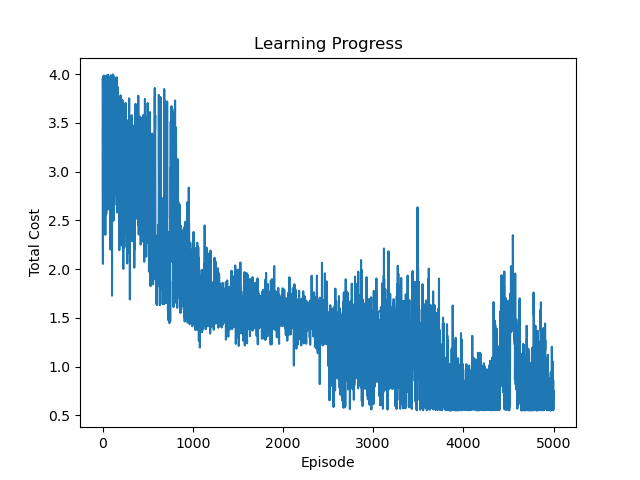

In [9]:
# Plot learning curve
plt.plot(learning_costs)
plt.xlabel('Episode')
plt.ylabel('Total Cost')
plt.title('Learning Progress')
plt.show()

### 4. Value Function and Policy

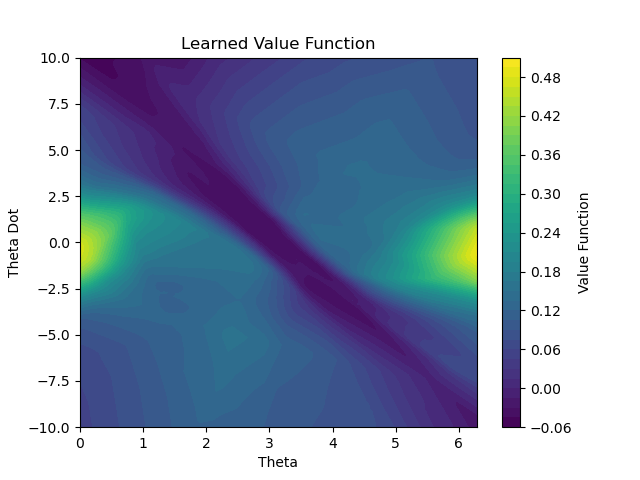

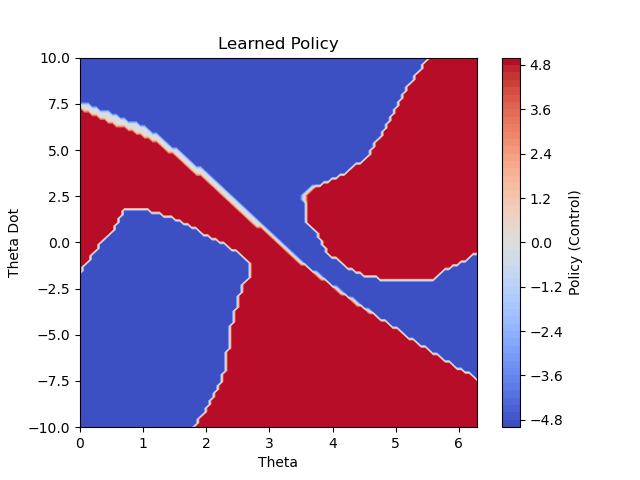

In [17]:
# Plot learned value function and policy
theta_vals = np.linspace(0, 2 * np.pi, 100)
theta_dot_vals = np.linspace(-10, 10, 100)
Theta, ThetaDot = np.meshgrid(theta_vals, theta_dot_vals)

ValueFunction = np.zeros_like(Theta)
Policy = np.zeros_like(Theta)

with torch.no_grad():
    for i in range(Theta.shape[0]):
        for j in range(Theta.shape[1]):
            xi = torch.tensor([Theta[i, j], ThetaDot[i, j]], dtype=torch.float)
            q_values = Q.q_network(xi.unsqueeze(0)).cpu().numpy().squeeze()
            # Negative because it's a cost
            ValueFunction[i, j] = np.min(q_values)
            Policy[i, j] = possible_controls[np.argmin(q_values)]

# Plot the value function
plt.figure()
plt.contourf(Theta, ThetaDot, ValueFunction, levels=50, cmap='viridis')
plt.colorbar(label='Value Function')
plt.xlabel('Theta')
plt.ylabel('Theta Dot')
plt.title('Learned Value Function')
plt.show()

# Plot the policy
plt.figure()
plt.contourf(Theta, ThetaDot, Policy, levels=50, cmap='coolwarm')
plt.colorbar(label='Policy (Control)')
plt.xlabel('Theta')
plt.ylabel('Theta Dot')
plt.title('Learned Policy')
plt.show()